# Final Assignment

### Group Members
1. Ethan McChristian
2. Haithem Merchaoui
3. Mitchell Tyse

## Task 1

### a) Create a dataset that contains observations on total CO2 emissions and population for all 
### countries in the WPI data

First things first, we're gonna import the packages we need & set our plot style

In [8]:
pip install pandas_datareader

     |████████████████████████████████| 109 kB 1.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import wb
import statsmodels.formula.api as smf

In [10]:
plt.style.use('ggplot')

Now it's time to import some data and do some wrangling. 

In [11]:
dff = wb.get_countries()
dff = dff.rename(columns={'name': 'country'}) #renaming so  column names match for merging

Originally, i removed the first 50 rows since those were all aggregates (df.iloc[49:]. I later found out that if I imported the data
and then filtered by region == 'Aggregates' I could do the same thing but better. 

In [12]:
df = wb.download(indicator=['EN.ATM.CO2E.KT', 'SP.POP.TOTL'], start = 2018, end=2018, country='all')
df2 = df.iloc[49:]
df2.columns = ['co2', 'population'] #renaming columns
df2 = df2.reset_index() #resetting index
df2['co2percap'] = df2.apply(
    lambda row: row.co2 / row.population *1000, axis=1) #found this online, was having trouble making new columns.
#we later figured out a better solution than this ^

In [13]:
df_merge = df2.merge(dff, on = 'country', how = 'outer') #merging the datasets

### b) Use the dataset to give a visual analysis of total CO2 emissions and per capita CO2 emissions 
### between countries.

I made different datasets with groupby means so that way I was sure what plot was doing when I made the upcoming histograms

In [14]:
means = df_merge.groupby('incomeLevel').mean()
means = means.reset_index()
reg = df_merge.groupby('region').mean()
reg = reg.reset_index() #always resetting the index that way I can just treat everything as column names

(referring to the code below) It looks like per capita co2 and co2 don't follow the same pattern. Region seems to have some effect on per capita co2 (enough to warrant further investigation). Income level has a lot to do with per capita co2 emissions (it seems).

/var/folders/3g/482p8nhn4dj908h5pyc9hsdc0000gn/T/ipykernel_24156/1870542781.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(reg['region'], rotation=35, ha='right') #rotating the x axis labels
/var/folders/3g/482p8nhn4dj908h5pyc9hsdc0000gn/T/ipykernel_24156/1870542781.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(means['incomeLevel'], rotation=35, ha='right')   # rotating the x axis labels


Text(0.5, 1.0, 'CO2 (kilotonnes)')

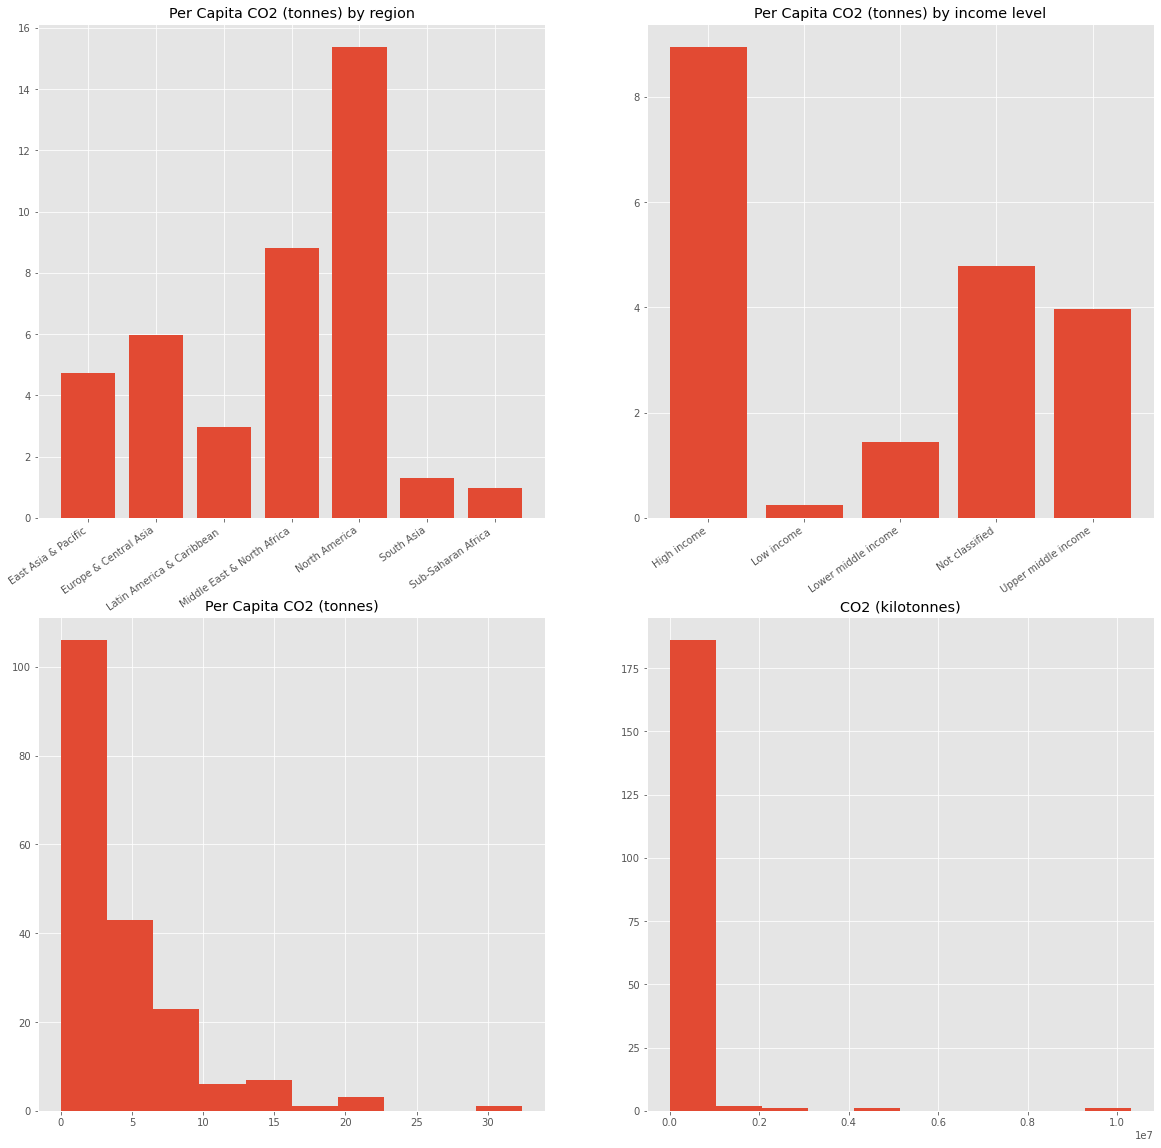

In [16]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (20,20))
ax[0,0].bar(reg['region'],
            reg['co2percap'],
            label = 'co2percap')
ax[0,1].bar(means['incomeLevel'],
            means['co2percap'],
            label = 'co2')
ax[1,0].hist(df_merge['co2percap'])
ax[1,1].hist(df_merge['co2'])
ax[0,0].set_xticklabels(reg['region'], rotation=35, ha='right') #rotating the x axis labels
ax[0,1].set_xticklabels(means['incomeLevel'], rotation=35, ha='right')   # rotating the x axis labels
ax[0,0].set_title('Per Capita CO2 (tonnes) by region')    
ax[0,1].set_title('Per Capita CO2 (tonnes) by income level')
ax[1,0].set_title('Per Capita CO2 (tonnes)')    
ax[1,1].set_title('CO2 (kilotonnes)')

#forget colors, rotate the x axis and add labels. First graph is co2 by region, 2nd is co2 by income, 3rd should be co2 

### c) Download data on 6 additional indicators...Analyze the relationship both visually and statistically. 

In [17]:
sixvar = wb.download(indicator=['EN.ATM.CO2E.KT','SP.DYN.LE00.MA.IN','SP.DYN.LE00.FE.IN','EN.POP.SLUM.UR.ZS','TX.VAL.MMTL.ZS.UN',
                                'NY.GNP.PCAP.PP.CD','AG.LND.AGRI.ZS', 'SP.POP.TOTL'], 
                     start = 2018, end=2018, country='all')
sixvar = sixvar.reset_index()
sixvar = sixvar.rename(columns = {'EN.ATM.CO2E.KT':'co2', 'SP.DYN.LE00.MA.IN':'male_life_exp', 'SP.DYN.LE00.FE.IN':'female_life_exp',
                         'EN.POP.SLUM.UR.ZS':'slums_pop_perc', 'TX.VAL.MMTL.ZS.UN':'ores_metals_exports_perc', 
                         'NY.GNP.PCAP.PP.CD':'gnp_percap', 'AG.LND.AGRI.ZS':'ag_perc_total_land', 'SP.POP.TOTL':'pop'})
sixvar['co2percap'] = sixvar['co2'] / sixvar['pop'] * 1000 #converting co2 to tonnes makes the graphs prettier
sixvar_merge = sixvar.merge(dff, on = 'country', how = 'outer')
sixvar_merge = sixvar_merge[sixvar_merge['region'] != "Aggregates"] #removing aggregates so we only have countries
sixvar_merge = sixvar_merge[sixvar_merge['region'] != "NaN"] #removing NAs

In [18]:
def get_model(formula, df):
    model = smf.ols(formula, data = df) 
    model = model.fit() #same function we used in lectures
    
    return model

In [19]:
formula = 'co2percap ~ male_life_exp + female_life_exp + slums_pop_perc + ores_metals_exports_perc + gnp_percap + ag_perc_total_land'
model = get_model(formula, sixvar_merge)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              co2percap   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     26.06
Date:                Sun, 06 Feb 2022   Prob (F-statistic):           3.41e-18
Time:                        15:38:43   Log-Likelihood:                -203.61
No. Observations:                 103   AIC:                             421.2
Df Residuals:                      96   BIC:                             439.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9044      3.017     -0.963      0.338      -8.893       3.085
male_life_exp               -0.0395      0.103     -0.385      0.701      -0.243       0.164
female_life_exp              0.0813      0.093      0.874      0.385      -0.103       0.266
slums_pop_perc              -0.0088      0.012     -0.710      0.479      -0.033       0.016
ores_metals_exports_perc     0.0107      0.012      0.891      0.375      -0.013       0.035
gnp_percap                   0.0001   1.92e-05      7.065      0.000    9.73e-05       0.000
ag_perc_total_land           0.0151      0.009      1.613      0.110      -0.003       0.034
==============================================================================
Omnibus:                       55.117   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.971
Skew:                           1.768   Prob(JB):                     7.00e-51
Kurtosis:                       9.428   Cond. No.                     3.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So the model suggests that there is strong multicollinearity. We thought we'd like to see that graphically, so we made a function that might help us visualize this!

Overall, our six variables don't explain per capita co2 emissions super well. But there's a lot of correlated factors with per capita co2 emissions, so I doubt any six variables would explain it (maybe that I'm assuming incorrectly, although)

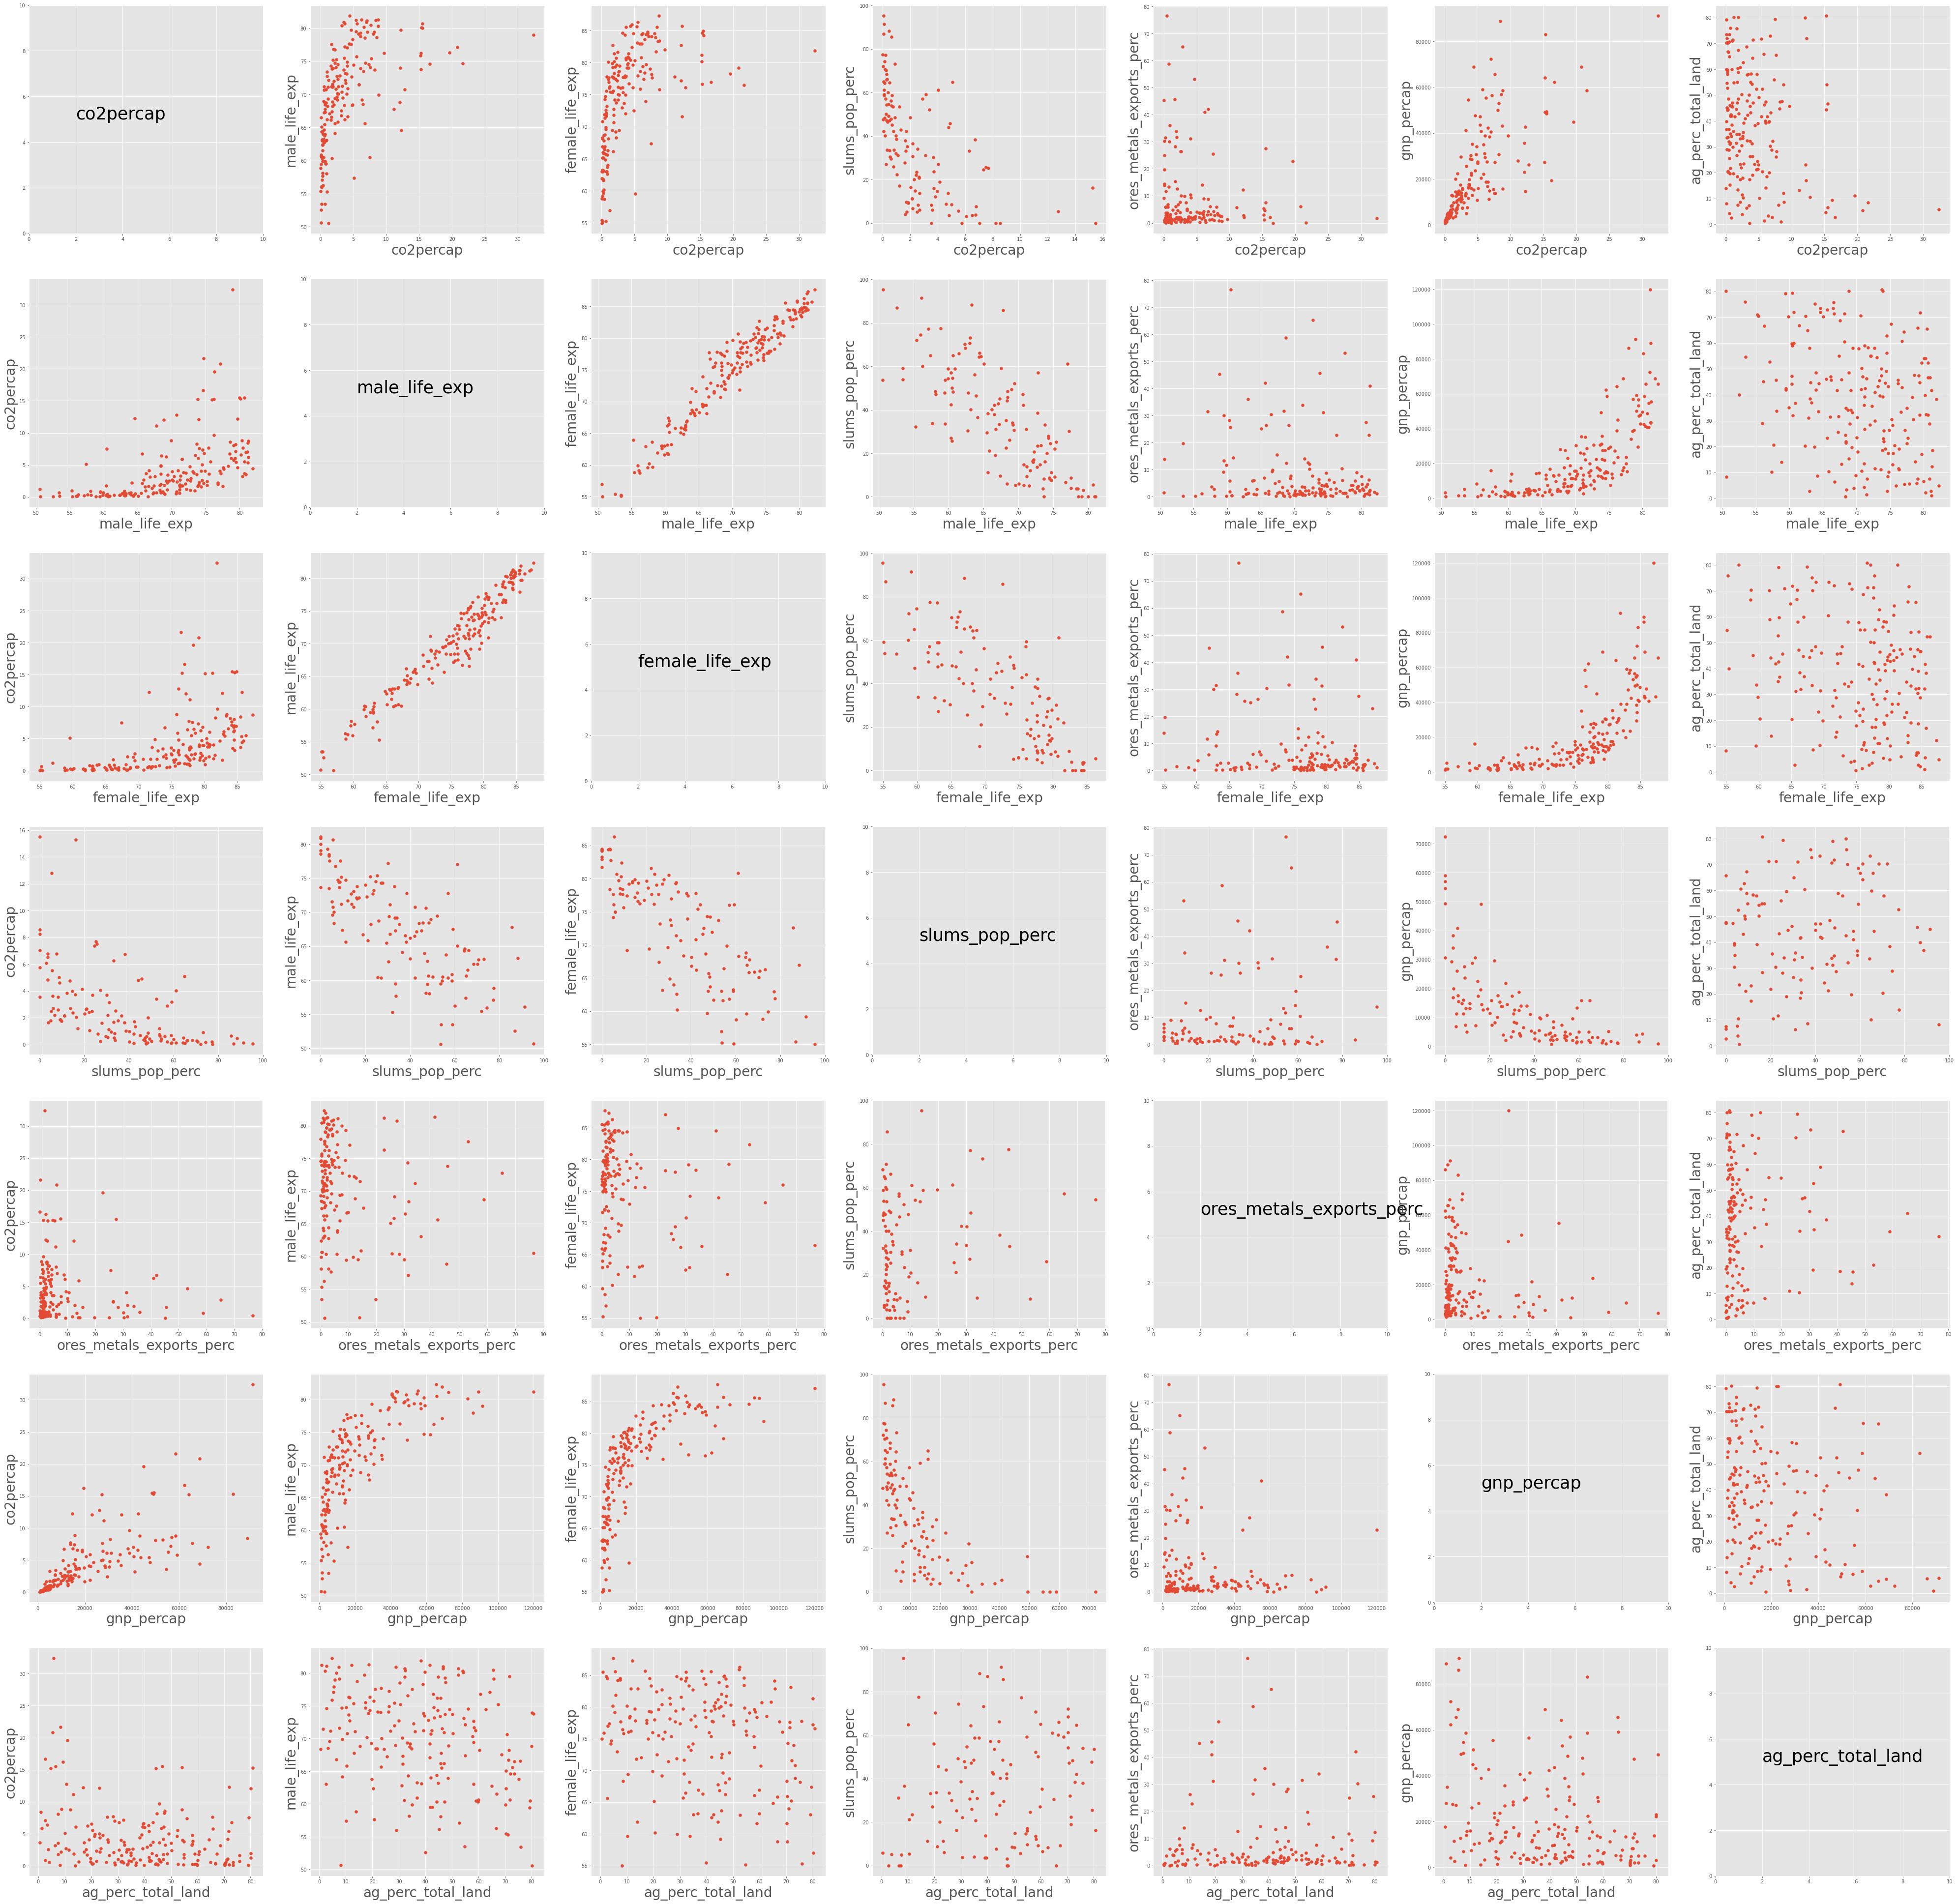

In [21]:
def plotmany(lst,df):
    coln = len(lst)
    fig, ax = plt.subplots(ncols=coln, nrows = coln, figsize = (coln*10,coln*10))
    q = 0 #i've heard there are better ways to do this, but I like doing it this way
    r = 0
    for i in lst: #iterate through the list for x axis
        for n in lst: #iterate through the list for y axis
            if i == n: # we don't want to regress 'co2' on 'co2', so we wrote this if clause
                ax[q,r].axis([0,10,0,10])
                ax[q,r].text(2,5,i, fontsize = coln*5)
            else: #this is what we end up using most of the time
                ax[q,r].scatter(df[i],
                       df[n])
                ax[q,r].set_ylabel(n, fontsize = coln*4)
                ax[q,r].set_xlabel(i, fontsize = coln*4)
            r+=1 #adding one to r after every graph
        q+=1 #adding 1 to q to go to the next row
        r=0 # resetting r so we can iterate through columns again
    plt.show()

        
plotmany(['co2percap','male_life_exp','female_life_exp','slums_pop_perc','ores_metals_exports_perc',
          'gnp_percap','ag_perc_total_land'], sixvar_merge) 

#okay, so not the prettiest but awesome way to look at how a lot of variables interact! With some more work I'll definitely
#use this code again
    

I mean there it is, lots of multicollinearity visualized. It seems if a lot of the variables are related to each other.

### d) doing the same thing with three variables

In [22]:
threevar = sixvar_merge[['country', 'co2percap', 'slums_pop_perc', 'gnp_percap', 'female_life_exp']] #filtering by columns
threevar.corr() #the usual routine

,co2percap,slums_pop_perc,gnp_percap,female_life_exp
co2percap,1.000000,-0.572382,0.757516,0.507537
slums_pop_perc,-0.572382,1.000000,-0.658121,-0.758763
gnp_percap,0.757516,-0.658121,1.000000,0.698840
female_life_exp,0.507537,-0.758763,0.698840,1.000000


In [23]:
formula2 = 'co2percap ~ female_life_exp + slums_pop_perc + gnp_percap' #making a new formula for a regression
model2 = get_model(formula2, threevar) #the usual routine, again
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              co2percap   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     52.85
Date:                Sun, 06 Feb 2022   Prob (F-statistic):           1.51e-21
Time:                        15:40:20   Log-Likelihood:                -244.53
No. Observations:                 119   AIC:                             497.1
Df Residuals:                     115   BIC:                             508.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1114      2.843     -0.039      0.969      -5.742       5.520
female_life_exp     0.0196      0.037      0.533      0.595      -0.053       0.092
slums_pop_perc     -0.0139      0.012     -1.188      0.237      -0.037       0.009
gnp_percap          0.0001   1.89e-05      7.347      0.000       0.000       0.000
==============================================================================
Omnibus:                       55.798   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.565
Skew:                           1.648   Prob(JB):                     8.47e-46
Kurtosis:                       8.568   Cond. No.                     2.99e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Less multicollinearity, but still not a great explaination of per capita co2 emissions.

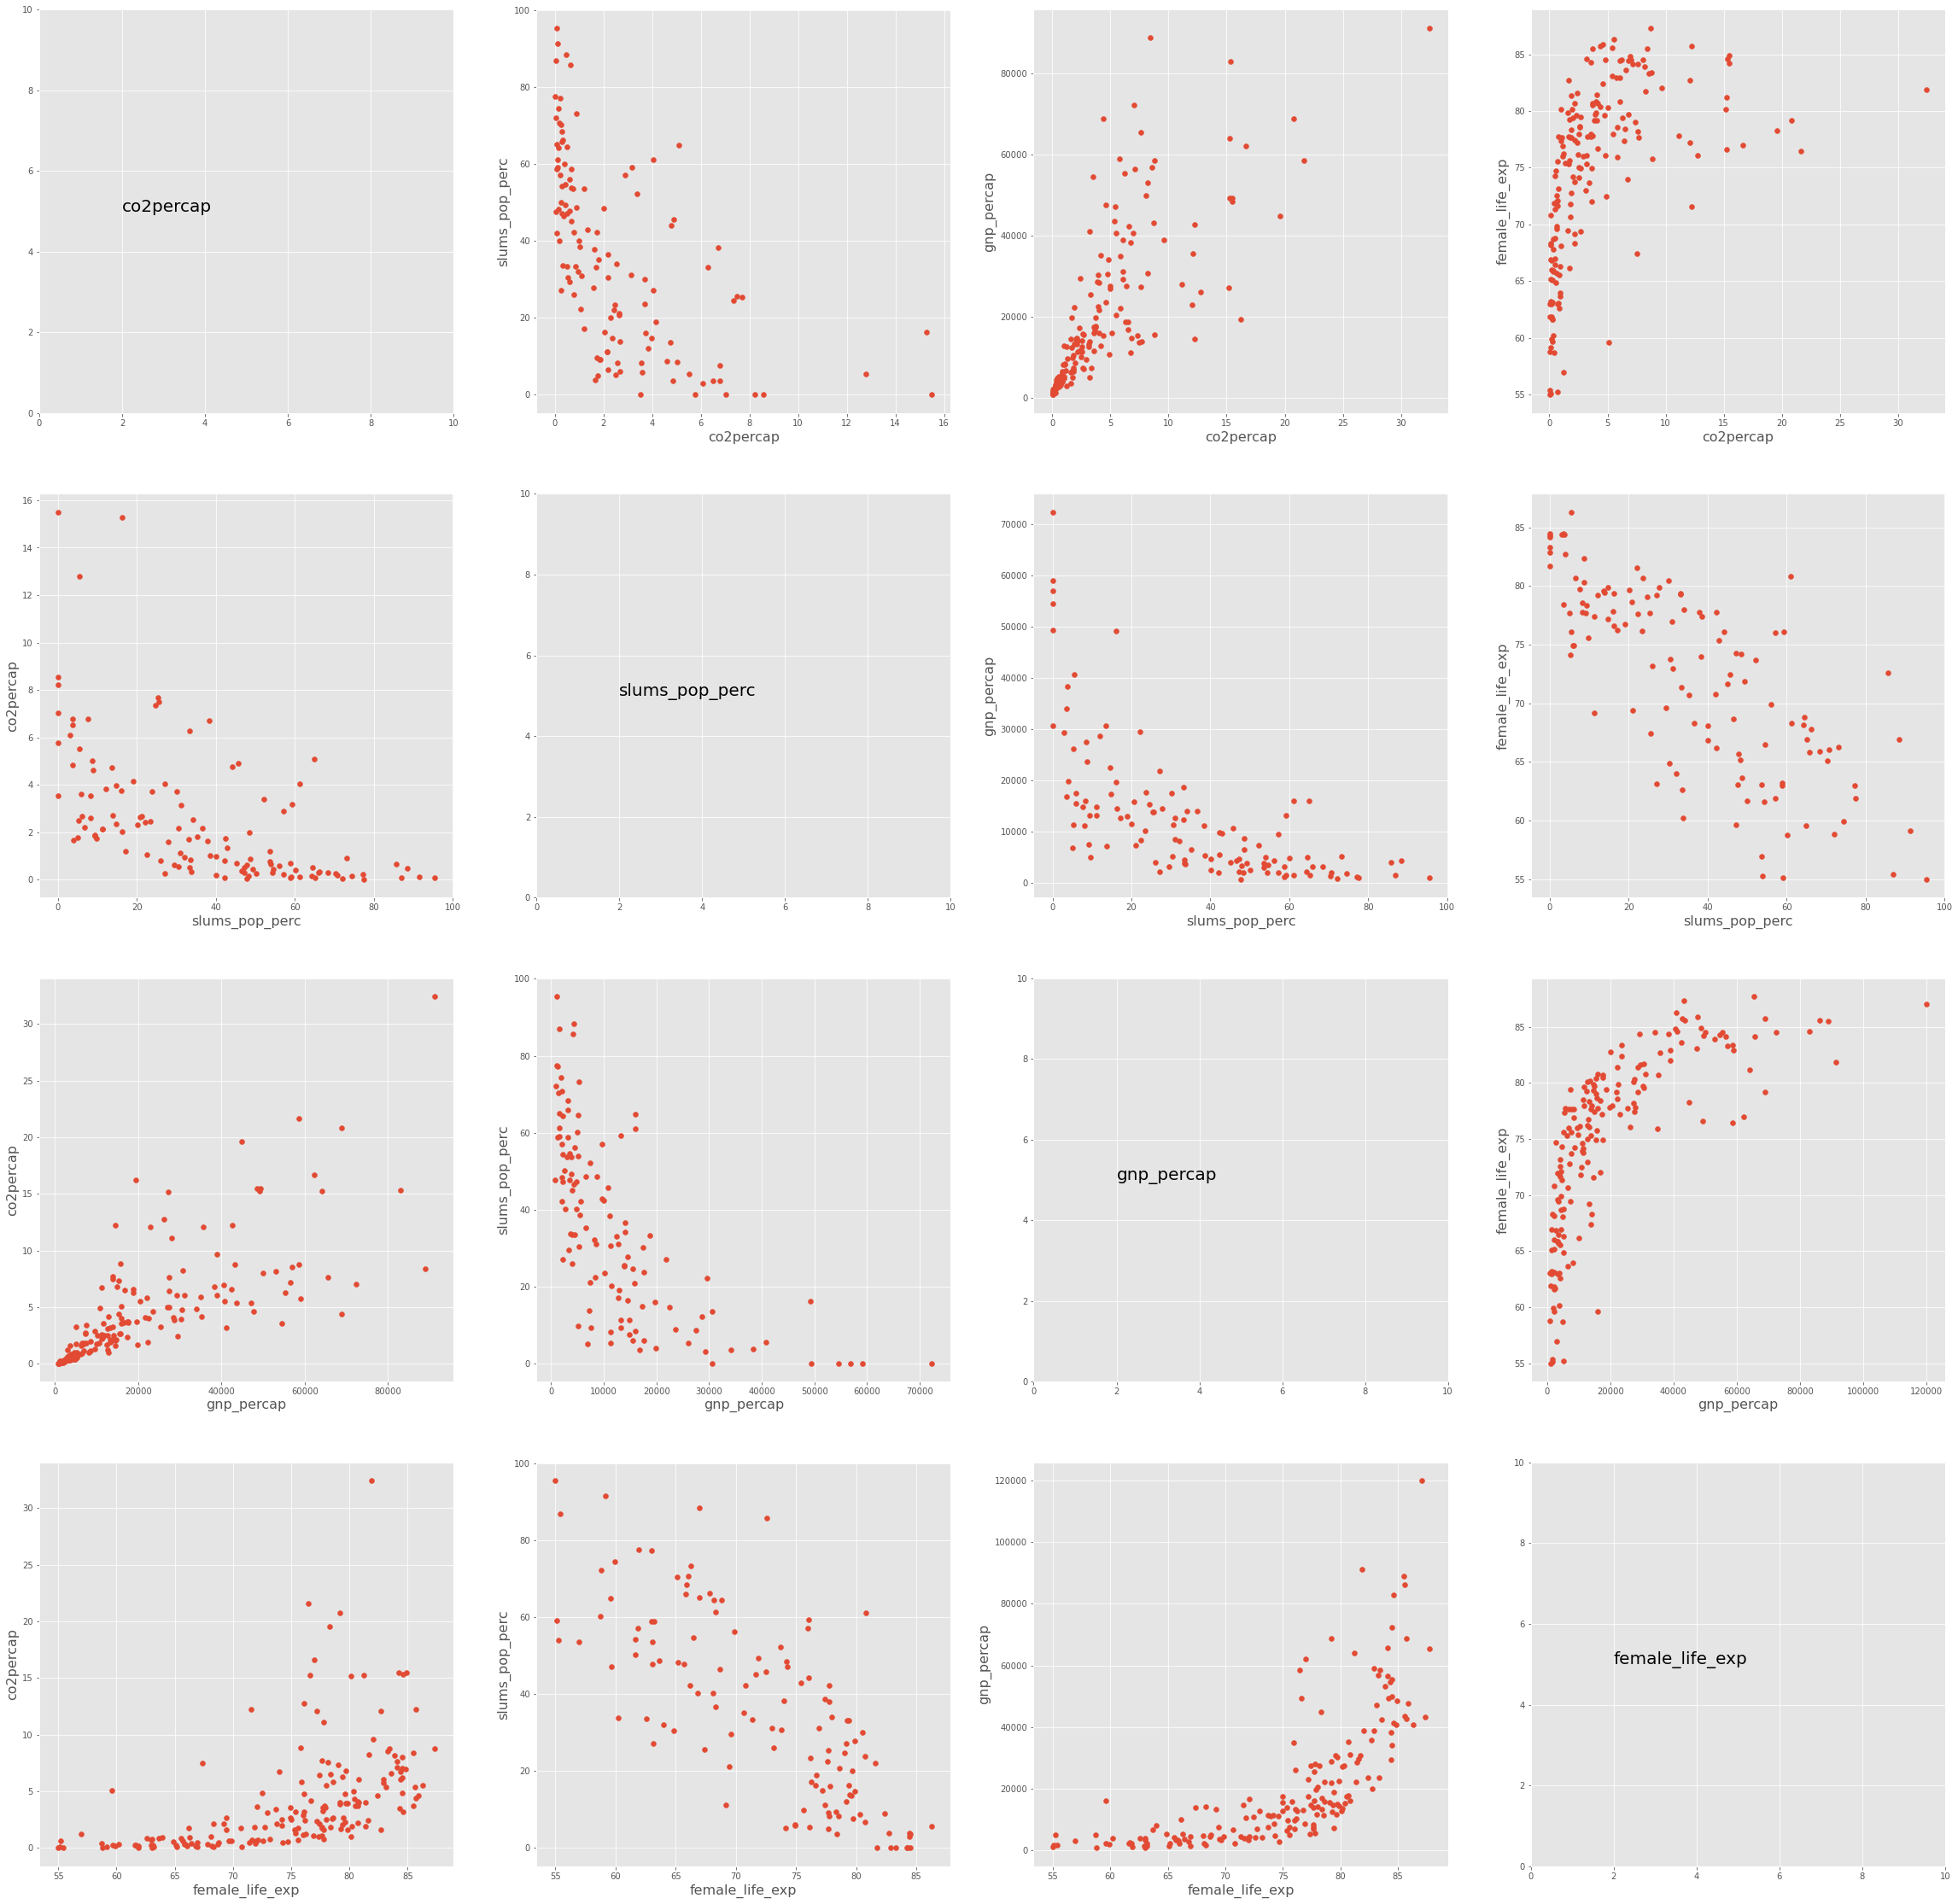

In [296]:
plotmany(['co2percap', 'slums_pop_perc', 'gnp_percap', 'female_life_exp'], threevar) #I just wanted to use this again because I like it a lot

## Part 2

In [299]:
import yfinance as yf

Importing and wrangling...

In [308]:
sp500_df = yf.download('^GSPC', 
                      start='2000-01-01', 
                      end='2022-01-22', 
                      progress=False) #downloading the data
sp500_df = sp500_df.reset_index() #resetting the index
sp500_df['Date'] = pd.to_datetime(sp500_df['Date']) #making 'Date' a datetime variable
sp500_df['year'] = sp500_df['Date'].dt.year #creating a year column out of the 'Date' columns
meanclose = sp500_df.groupby('year').mean('Close') #grouping 'Close' by year and then taking the average
sp_avg = meanclose['Close'] #new vector
sp_avg = pd.DataFrame(sp_avg) #turning the vector into a dataframe
sp_avg = sp_avg.reset_index() #resetting the idnex
sp_avg['year']=sp_avg['year'].astype(int) #making the year column an integer
sp_avg = sp_avg[sp_avg['year']< 2019] #filtering to get rid of mismatches when we merge
sp_avg = sp_avg[sp_avg['year']>= 2000] #^

In [313]:
bf = wb.download(indicator=['EN.ATM.CO2E.KT'], start = 2000, end=2018, country='all') #had to change 'df'
#so we had different dataframes in part 1 & 2
bf = bf.reset_index()
bf['year']=bf['year'].astype(int) #making year an integer

Still wrangling...

In [316]:
bff = wb.get_countries() #same, bff instead of dff
bff = bff.rename(columns={'name': 'country'}) #renaming to merge
data = bf.merge(bff, on = 'country', how = 'outer') #merging
data = data.rename(columns={'EN.ATM.CO2E.KT':'co2'}) #renaming for easier use
data = data[data['region'] != 'Aggregates'] #filtering out aggregates
data = data[data['region'].notnull()] #filtering out NAs in region
data = data[data['year'].notnull()] #filtering out NAs in year
data['year']=data['year'].astype(int) #making year and integer variable

The big shebang, writing the function using all this data

Hey boss, what country do you want data for?:Norway


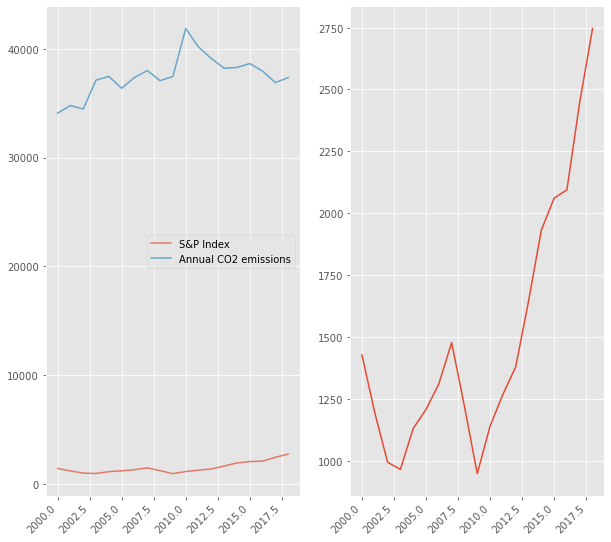

In [315]:
def funnn():
    country = input('Hey boss, what country do you want data for?:') #prompting the user to input the country they want
    db1 = data[data['country'] == country] #filtering the dataset to only include the country
    graphingdata = db1.merge(sp_avg, on = 'year', how = 'outer') #merging the country dataset with S&P average
    fig, ax = plt.subplots(ncols = 2, figsize = (10,10)) #making two figures
    ax[0].plot(graphingdata['year'], #first figure has two graphs but sometimes co2 is way bigger than S&P
           graphingdata['Close'],
            label = 'S&P Index',
           alpha = .7)
    ax[0].plot(graphingdata['year'], #this first graph always favors co2 on axis dimensions
           graphingdata['co2'], 
           alpha = .7,
           label = 'Annual CO2 emissions')
    ax[0].legend() #making a legend
    fig.autofmt_xdate(rotation=45) #rotating x axis labels
    ax[1].plot(graphingdata['year'], #so here is a second figure that gives a closer up of S&P index
                   graphingdata['Close'])
funnn()

The above function would be better with a ton of if else functions, but I assume that my boss can spell the countries correctly (she is my boss, she must've gotten to that position somehow)